## Perform PCA with 90 % retained variances for our histology UNI embeddings.
### Also explore stratified sampling strategies and one-hot-encode available information

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.decomposition import PCA

import scanpy as sc
import pandas as pd
import anndata as ad
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, OneHotEncoder

In [2]:
adata_histo = sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/translation1/adata_histo.h5ad")
adata_histo

AnnData object with n_obs × n_vars = 190659 × 1536
    obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice'
    obsm: 'brain_area_onehot', 'uni_embedding'

In [3]:
X = adata_histo.obsm["uni_embedding"]
X.shape

(190659, 1536)

95% variance reached at k=368
99% variance reached at k=922


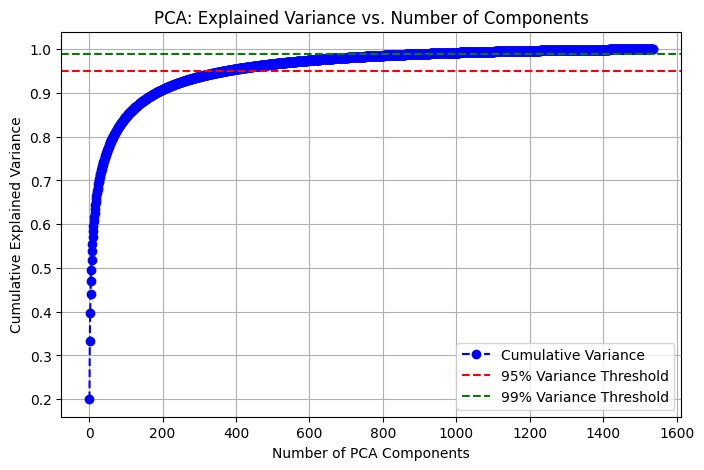

In [10]:
def plot_pca_variance(X):
    k = X.shape[1]  # Number of original features

    # Perform PCA
    pca = PCA(n_components=k)
    pca.fit(X)

    # Explained variance ratio for each component
    explained_variance = pca.explained_variance_ratio_

    # Cumulative sum of explained variance
    cumulative_variance = np.cumsum(explained_variance)
    k_95 = np.min(np.where(cumulative_variance >= 0.95)) + 1
    k_99 = np.min(np.where(cumulative_variance >= 0.99)) + 1
    print(f"95% variance reached at k={k_95}")
    print(f"99% variance reached at k={k_99}")

    # Plot the cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(
        range(1, k + 1), cumulative_variance, marker='o', linestyle='--', color='b', 
        label="Cumulative Variance")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA: Explained Variance vs. Number of Components")
    plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
    plt.axhline(y=0.99, color='g', linestyle='--', label="99% Variance Threshold")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage (assuming X is already defined with shape (N, k))
# X = np.random.rand(1000, 50)  # Example: Replace with your actual data
plot_pca_variance(X)

In [11]:
### Annotate in the anndata
pca = PCA(n_components=368)
pca_emb = pca.fit_transform(X)
adata_histo.obsm["uni_pca_95"] = pca_emb
pca_emb.shape

(190659, 368)

In [13]:
# Save in the data folder
adata_histo.write_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_histo.h5ad")

In [4]:
adata_histo = sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_histo.h5ad")

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


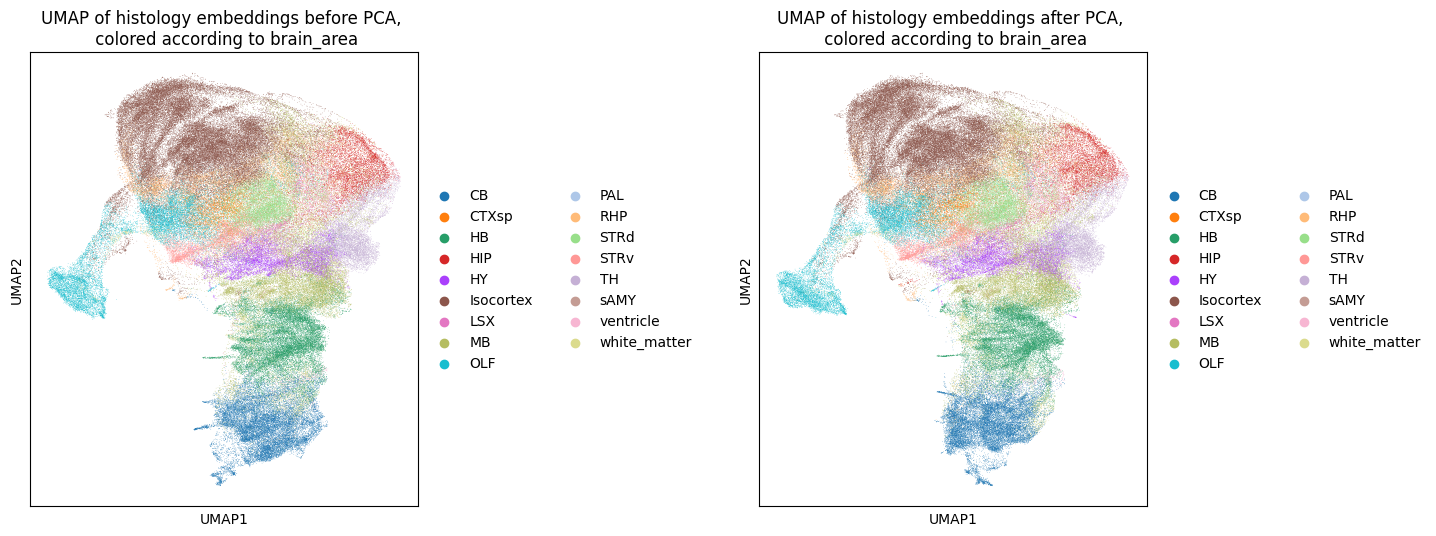

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pp.neighbors(adata_histo, n_neighbors=20, random_state=42, use_rep="uni_embedding")
sc.tl.umap(adata_histo)
sc.pl.umap(adata_histo, color="brain_area", ax=ax1, show=False)
ax1.set_title(
    "UMAP of histology embeddings before PCA, \n colored according to brain_area"
)

sc.pp.neighbors(adata_histo, n_neighbors=20, random_state=42, use_rep="uni_pca_95")
sc.tl.umap(adata_histo)
sc.pl.umap(adata_histo, color="brain_area", ax=ax2, show=False)
ax2.set_title(
    "UMAP of histology embeddings after PCA, \n colored according to brain_area"
)
plt.tight_layout(pad=3.0)
plt.show()

### Stratified sampling by brain area

#### Start by removing the other brain half that is not in our st data

In [27]:
max_z = max(sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/translation1/adata_st.h5ad").obs["z_st"])
sample_mask = (adata_histo.obs["z_st"] <= max_z).to_numpy()
adata_sampled = adata_histo[sample_mask]
adata_sampled.shape

(100313, 1536)

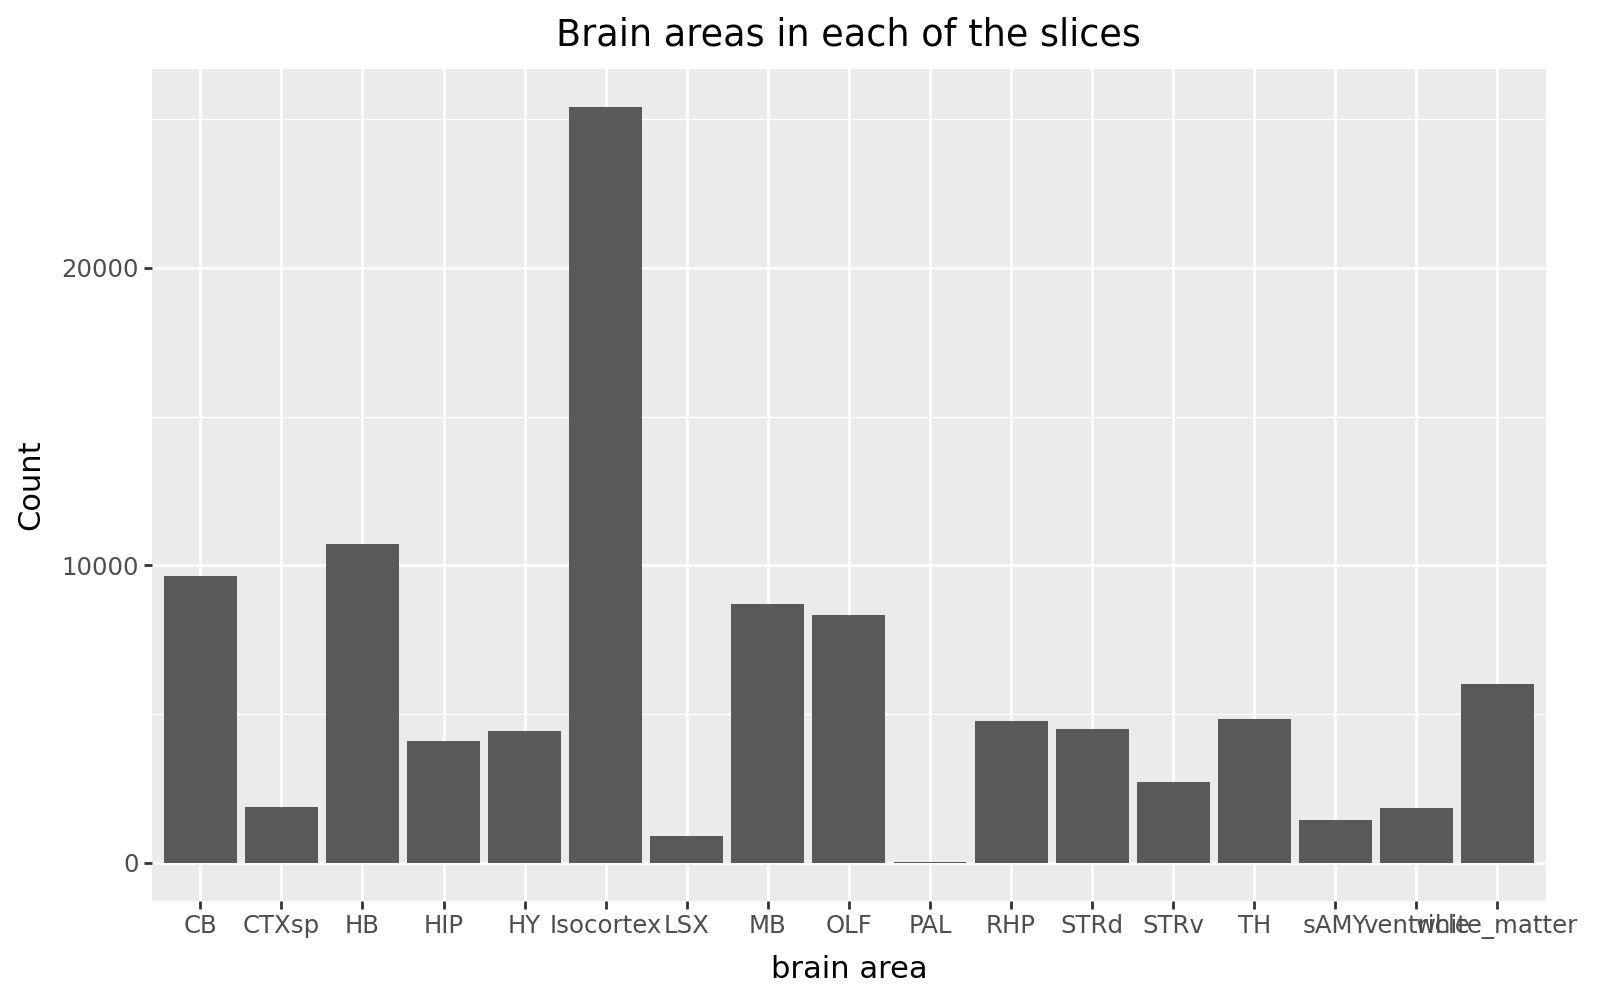

In [17]:
df = adata_sampled.obs.loc[:, ("brain_area",)]

plot = (
    ggplot(df, aes(x='brain_area')) +
    geom_bar(position='dodge') +  # Dodge separates bars for each group
    labs(title="Brain areas in each of the slices", x="brain area", y="Count") +
    theme(figure_size=(8,5))
)
plot

In [6]:
(adata_sampled.obs.loc[:, ("brain_area",)] == "PAL").sum()

brain_area    48
dtype: int64

### Now use stratified sampling to get a result dimension of 50.000 x 368

Sample size 50156


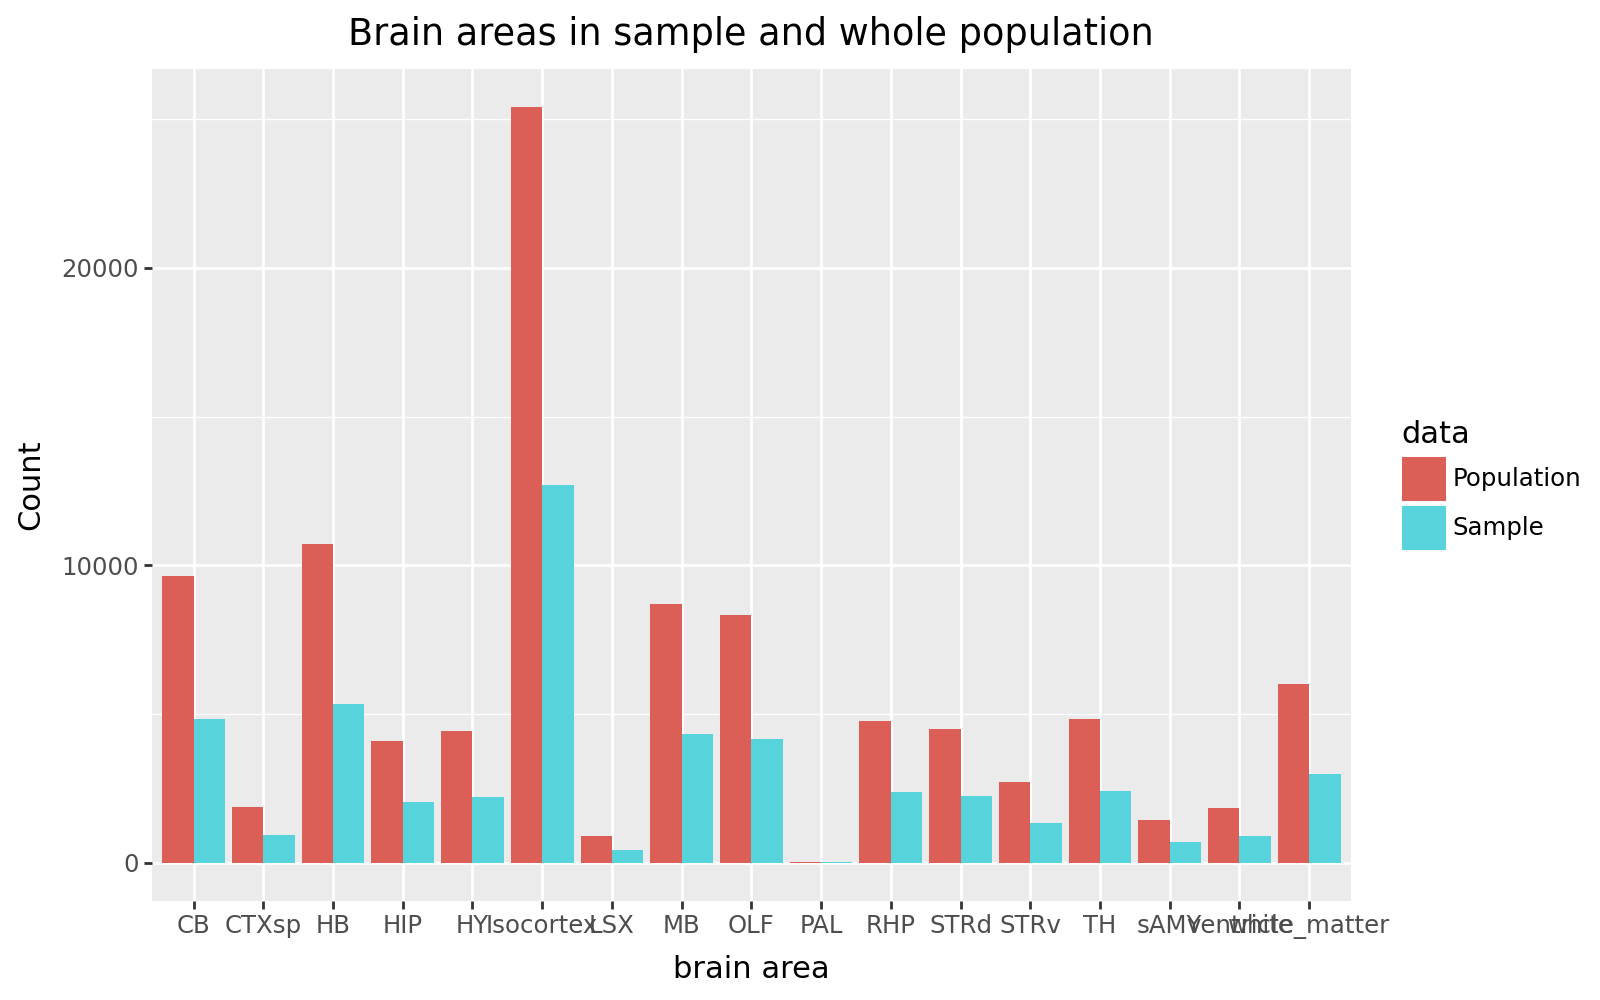

In [19]:
stratified_index, _ = train_test_split(
    range(adata_sampled.shape[0]), test_size=0.5, stratify=adata_sampled.obs["brain_area"]
)
print("Sample size", len(stratified_index))
df1 = adata_sampled.obs.loc[:, ("brain_area",)].reset_index(drop=True).iloc[stratified_index, :].assign(data = "Sample")
df2 = adata_sampled.obs.loc[:, ("brain_area",)].assign(data = "Population")

df = pd.concat((df1, df2))

plot = (
    ggplot(df, aes(x='brain_area', fill = "data")) +
    geom_bar(position='dodge') +  # Dodge separates bars for each group
    labs(title="Brain areas in sample and whole population", x="brain area", y="Count") +
    theme(figure_size=(8,5))
)
plot

### Remove 156 to exactly match the dimensions of spatial data

In [20]:
stratified_index = stratified_index[0:-156]
len(stratified_index)

50000

In [39]:
true_indices = np.flatnonzero(sample_mask)

keep_indices = true_indices[stratified_index]

# Step 3: Set all to False, then re-enable only the ones you want
sample_mask[:] = False
sample_mask[keep_indices] = True
sample_mask.sum()

np.int64(50000)

### Save as a new adata

In [14]:
adata_sampled = adata_sampled[stratified_index, :]
adata_sampled.shape

(50000, 1536)

In [15]:
adata_sampled.write_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/translation2/adata_histo.h5ad")

### Save within adata histo

In [42]:
adata_histo.obs["in_sample"] = sample_mask

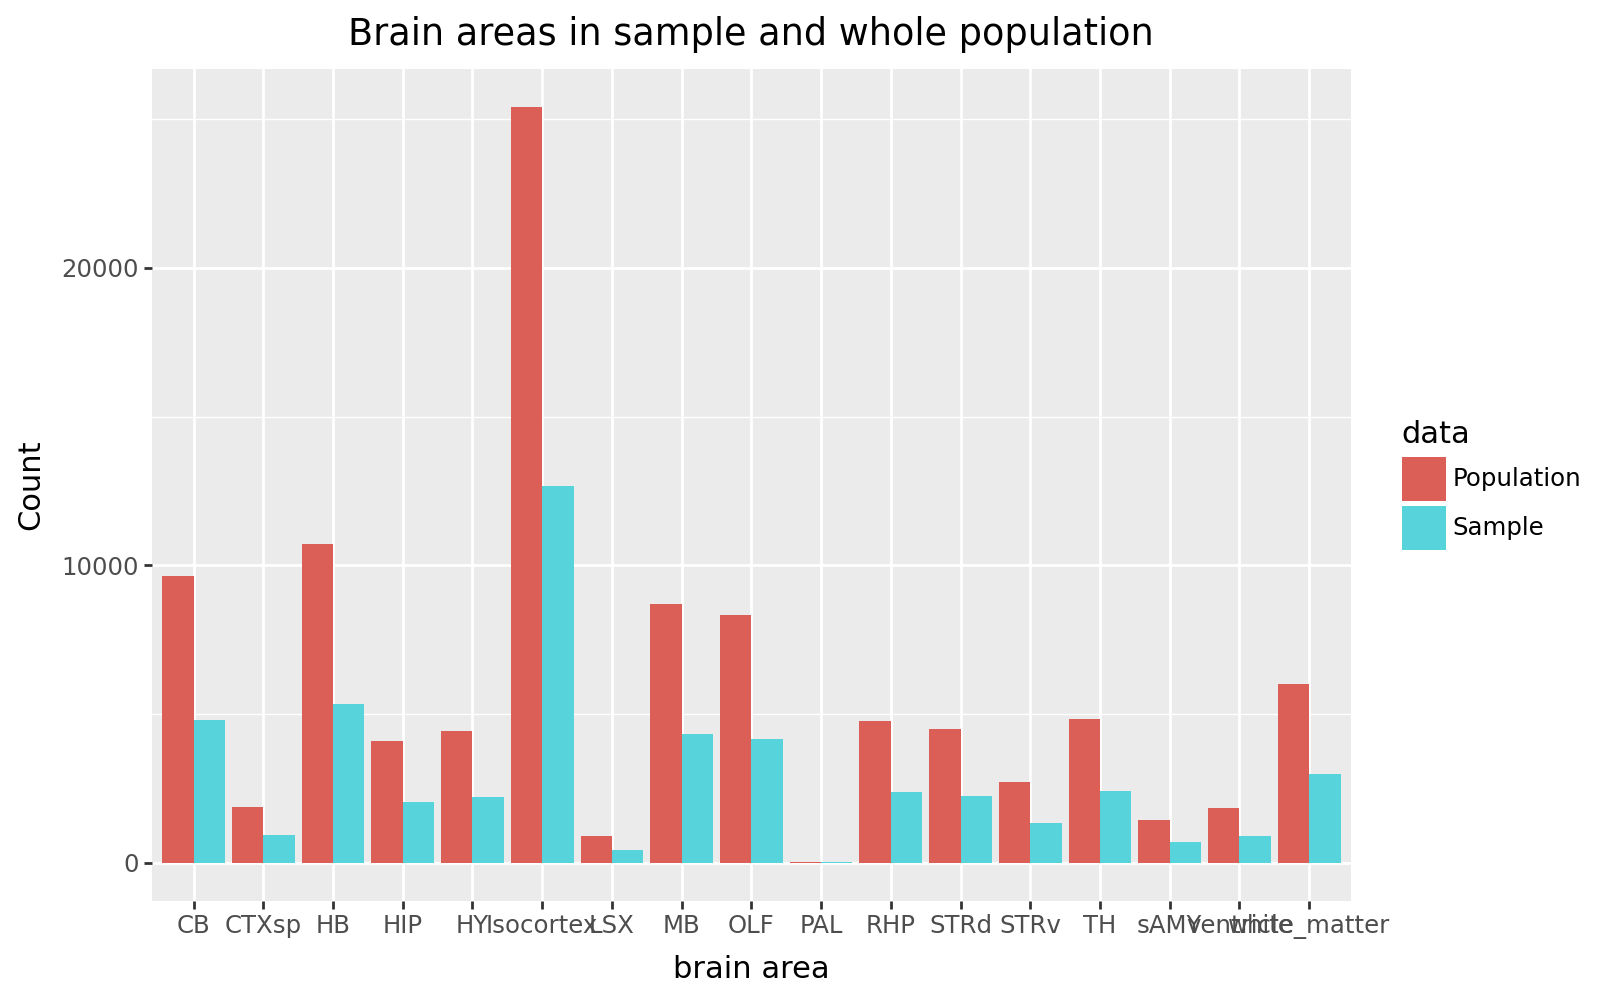

In [43]:
df1 = adata_histo.obs.loc[adata_histo.obs["in_sample"], ("brain_area",)].reset_index(drop=True).assign(data = "Sample")
df2 = adata_sampled.obs.loc[:, ("brain_area",)].assign(data = "Population")

df = pd.concat((df1, df2))

plot = (
    ggplot(df, aes(x='brain_area', fill = "data")) +
    geom_bar(position='dodge') +  # Dodge separates bars for each group
    labs(title="Brain areas in sample and whole population", x="brain area", y="Count") +
    theme(figure_size=(8,5))
)
plot

In [44]:
adata_histo.write_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_histo.h5ad")

# Add location and  slide information for extra gromov wasserstein terms

In [3]:
adata_st = sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_st.h5ad")
adata_histo =  sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_histo.h5ad")

In [6]:
adata_histo.obsm["uni_pca_95"].min(), adata_histo.obsm["uni_pca_95"].max()

(np.float32(-13.837733), np.float32(11.572848))

In [7]:
# Location information
scaler = StandardScaler()
# uni_pca_scaled = scaler.fit_transform(adata_histo.obsm["uni_pca_95"])
# uni_pca_scaled = mm_scaler.fit_transform(uni_pca_scaled)
uni_pca_scaled = normalize(adata_histo.obsm["uni_pca_95"], norm = "l2")

uni_pca_scaled.min(), uni_pca_scaled.mean(), uni_pca_scaled.max()

(np.float32(-0.8854729), np.float32(8.430279e-06), np.float32(0.79413754))

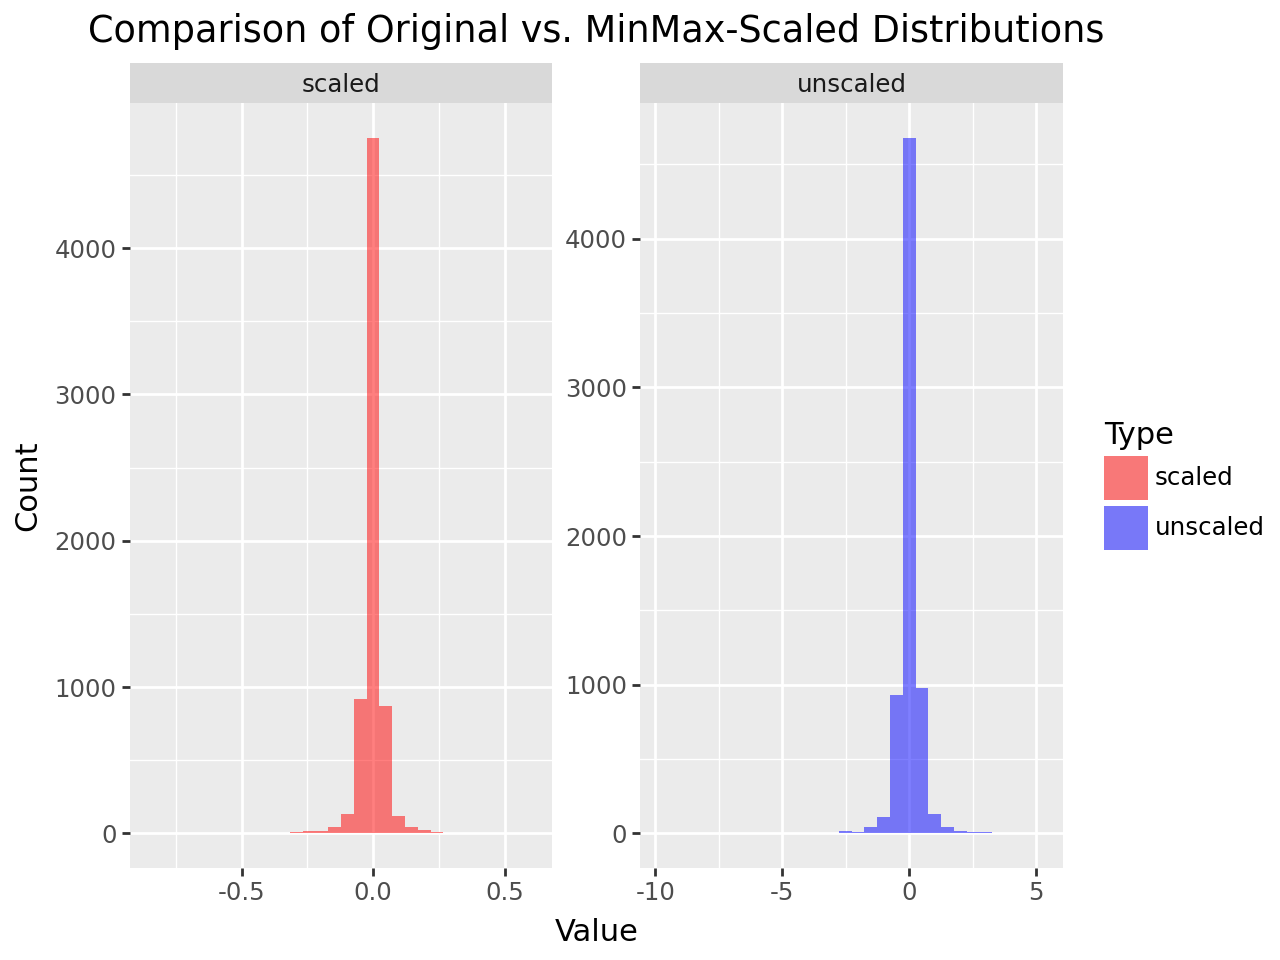

In [8]:
# Convert to long-format DataFrame for plotnine
df1 = pd.DataFrame({
    "Value": adata_histo.obsm["uni_pca_95"].ravel()
}).sample(n = 7000).assign(Type = "unscaled")
df2 = pd.DataFrame({
    "Value": uni_pca_scaled.ravel()
}).sample(n = 7000).assign(Type = "scaled")
df = pd.concat((df1,df2))

# Plot using plotnine
p = (ggplot(df, aes(x="Value", fill="Type")) +
     geom_histogram(bins=30, alpha=0.5, position="identity") +
     facet_wrap("~Type", scales = "free") +  # One histogram per feature
     scale_fill_manual(values=["red", "blue"]) +
     labs(title="Comparison of Original vs. MinMax-Scaled Distributions",
             x="Value", y="Count"))
p

### Append them and store as new obsm key
Since we have 368 features in the range (-0.8, 0.8) and only 3 coordinates in the range (0,1), the features will dominate the coordinate information in the wasserstein distance, but the coordinates might be even more valuable to judge whether two patches are similar. So i will scale them by 4 to give them more impact in the GW term. The standard implementation uses a squared euclidean distance, so let's see the impact of the new term

In [9]:
mm_scaler = MinMaxScaler(feature_range = (0, 4))
histo_coords_scaled = mm_scaler.fit_transform(adata_histo.obs.loc[:, ["x_st", "y_st", "z_st"]])
histo_coords_scaled.min(), histo_coords_scaled.mean(), histo_coords_scaled.max()

(np.float64(0.0),
 np.float64(2.0686418583399004),
 np.float64(4.000000000000001))

In [10]:
rng = np.random.default_rng(12345)
rints = rng.integers(low=0, high=190659, size=100000)

np.mean(np.vstack(
    [np.sum(np.square(histo_coords_scaled[rints[i]] - histo_coords_scaled[rints[i+1]]))
     for i in range(len(rints) - 1)]
))

np.float64(4.67306731534631)

In [11]:
np.mean(np.vstack(
    [np.sum(np.square(uni_pca_scaled[rints[i]] - uni_pca_scaled[rints[i + 1]]))
     for i in range(len(rints) - 1)]
))

np.float32(2.0012507)

==> Impact of coordinates ~twice that of the embedding

In [12]:
uni_pca_plus_coords = np.hstack((uni_pca_scaled, histo_coords_scaled))
adata_histo.obsm["uni_pca_plus_coords"] = uni_pca_plus_coords
uni_pca_plus_coords.shape

(190659, 371)

## Repeat for spatial data

In [13]:
adata_st.obsm["pca_embedding"].min(), adata_st.obsm["pca_embedding"].mean(), adata_st.obsm["pca_embedding"].max()

(np.float64(-6.1475773),
 np.float64(0.029949651181411983),
 np.float64(7.203564089814814))

In [14]:
st_pca_scaled = normalize(adata_st.obsm["pca_embedding"], norm = "l2")

st_pca_scaled.min(), st_pca_scaled.mean(), st_pca_scaled.max()

(np.float64(-0.7621821187337515),
 np.float64(0.0055784186282455015),
 np.float64(0.9106579053029137))

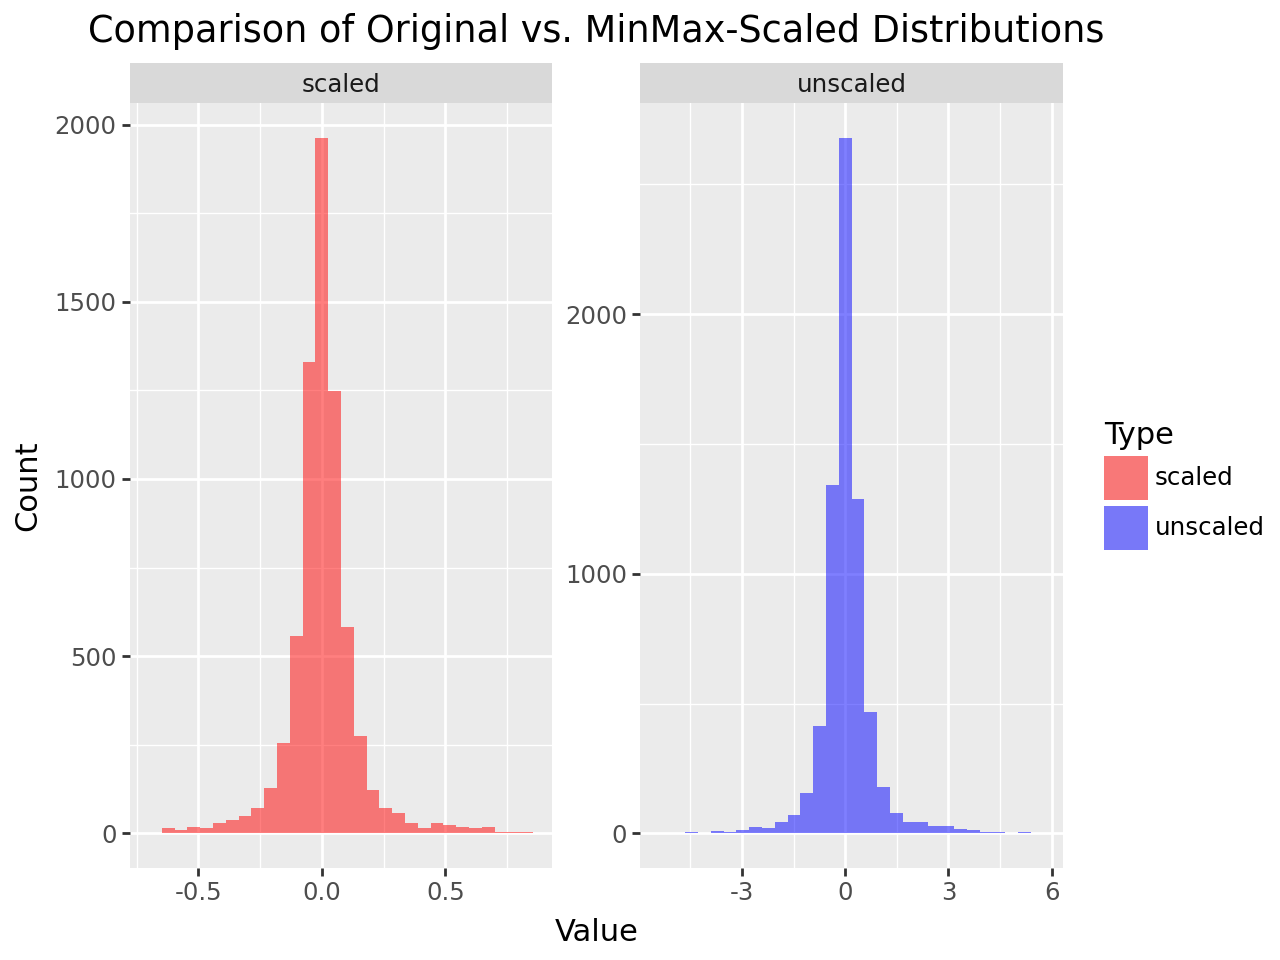

In [15]:
# Convert to long-format DataFrame for plotnine
df1 = pd.DataFrame({
    "Value": adata_st.obsm["pca_embedding"].ravel()
}).sample(n = 7000).assign(Type = "unscaled")
df2 = pd.DataFrame({
    "Value": st_pca_scaled.ravel()
}).sample(n = 7000).assign(Type = "scaled")
df = pd.concat((df1,df2))

# Plot using plotnine
p = (ggplot(df, aes(x="Value", fill="Type")) +
     geom_histogram(bins=30, alpha=0.5, position="identity") +
     facet_wrap("~Type", scales = "free") +  # One histogram per feature
     scale_fill_manual(values=["red", "blue"]) +
     labs(title="Comparison of Original vs. MinMax-Scaled Distributions",
             x="Value", y="Count"))
p

### Add the information about slides
In the spatial transcriptomics setting, we do not have any reliable information about coordinates, but we do get slide numbers (categoricals). So we can add them as OneHotEncoded feature vectors to get the GW distance to recognize same slide measurements. Before, let's check if the PCA automatically carries this information

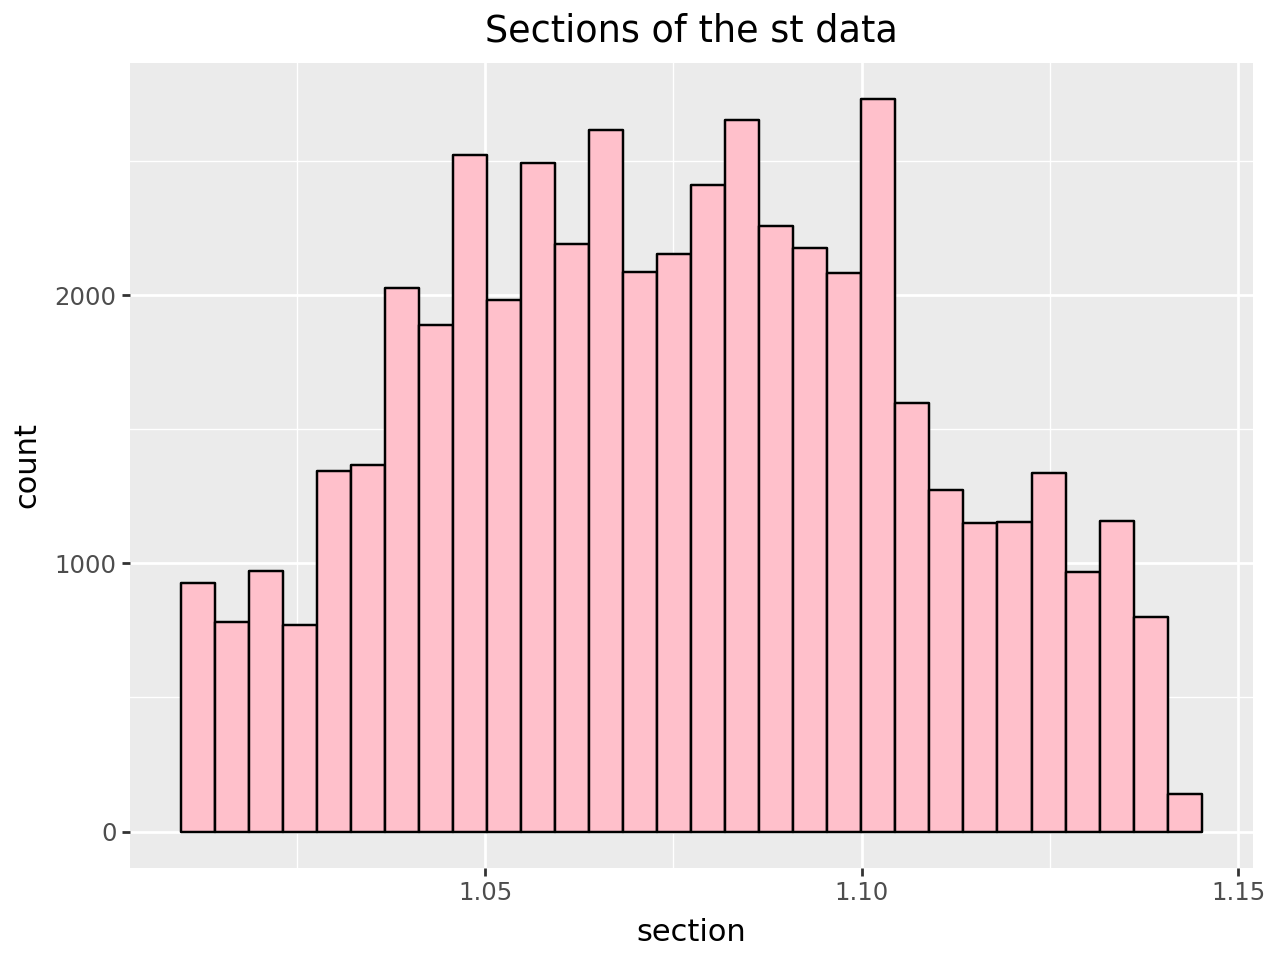

In [16]:
adata_st.obs["section"] = adata_st.obs["brain_section_label"].str.split("-").str[-1].astype(float)
p = (ggplot(adata_st.obs, aes(x="section")) +
     geom_histogram(bins=30,  fill = "pink", color = "black", position="identity") +
     ggtitle("Sections of the st data")
    )
p

In [17]:
sc.pp.neighbors(adata_st, n_neighbors=20, random_state=42, use_rep="pca_embedding")
sc.tl.umap(adata_st)

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


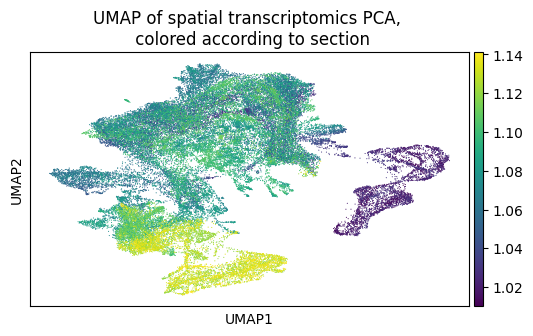

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sc.pl.umap(adata_st, color="section", ax=ax, show=False)
ax.set_title(
    "UMAP of spatial transcriptomics PCA, \n colored according to section"
)
# ax.get_legend().remove()
plt.tight_layout(pad=3.0)
plt.show()

==> The sections do show up, especially at the very front / back of the brain. But in the middle, they do not have enough of an impact to drive the UMAP. Let's add them explicitly, but not give them too much weight

In [19]:
enc = OneHotEncoder()
sections = enc.fit_transform(adata_st.obs["brain_section_label"].to_numpy().reshape(-1,1))
sections = sections.toarray()
sections.shape

(50000, 129)

In [20]:
rng = np.random.default_rng(12345)
rints = rng.integers(low=0, high=49999, size=50000)

np.mean(np.vstack(
    [np.sum(np.square(st_pca_scaled[rints[i]] - st_pca_scaled[rints[i+1]])) for i in range(len(rints) - 1)]
))

np.float64(1.8353497080129788)

In [21]:
np.mean(np.vstack(
    [np.sum(np.square(sections[rints[i]] - sections[rints[i + 1]])) for i in range(len(rints) - 1)]
))

np.float64(1.9815996319926399)

The average distance between two points in the st PCA space is 1.83, for the slides it is 1.98. This is similar enough, so the GW will account for both when calculating distances

In [22]:
st_pca_plus_slides = np.hstack((st_pca_scaled, sections))
adata_st.obsm["pca_plus_slides"] = st_pca_plus_slides
st_pca_plus_slides.shape

(50000, 179)

## Make distances comparable
in gromov wasserstein distance, we look at the difference between two pairs. So how do i scale both modalities (consisting of latent space embeddings) so that the distances of actually similar points (here measurements taken from the mouse brain) are also similar => FGW of 0? Because if the scaling is wrong, it might try to have very close pairs of points in modality 1 together with very far pairs from modality 2, if modality 1 is just a lot bigger in terms of values

In [25]:
st_dists = pairwise_distances(
    st_pca_plus_slides[np.random.choice(st_pca_plus_slides.shape[0], 20000, replace=False)], 
    metric ="sqeuclidean"
)
histo_dists = pairwise_distances(
    uni_pca_plus_coords[np.random.choice(uni_pca_plus_coords.shape[0], 20000, replace=False)], 
    metric ="sqeuclidean"
)
st_dists.shape, histo_dists.shape

((20000, 20000), (20000, 20000))

In [30]:
df_stats = pd.DataFrame({
    "mean": [histo_dists.mean(), st_dists.mean()],
    "std": [histo_dists.std(), st_dists.std()],
    "Modality": ["Histology", "Spatial"]
})
df_stats

,mean,std,Modality
0,6.696103,3.264351,Histology
1,3.820846,0.768404,Spatial


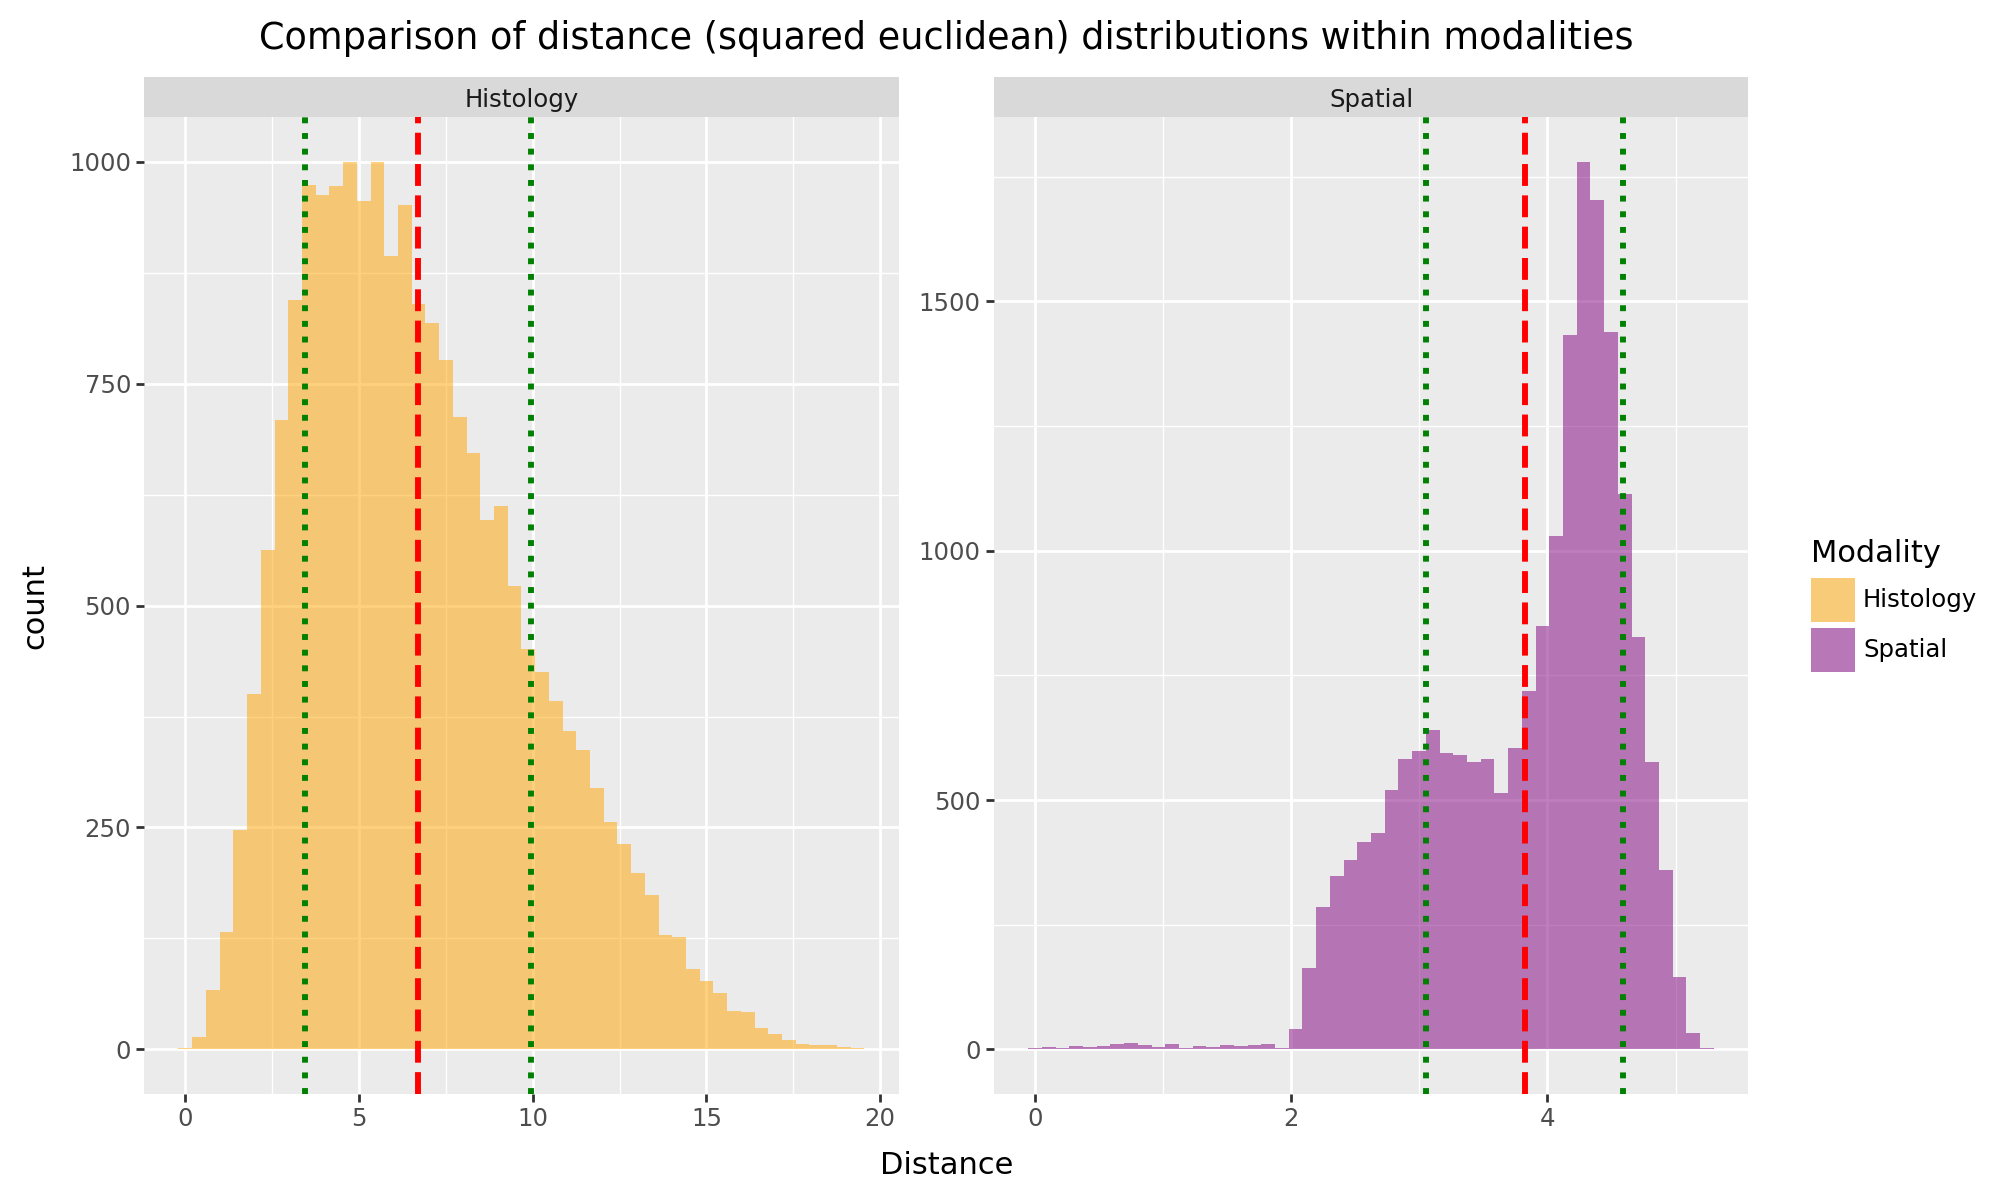

In [32]:
# Plot the distance distributions
df1 = pd.DataFrame({
    "Distance": np.random.choice(histo_dists.ravel(), 20000, replace = False)
}).assign(Modality = "Histology")
df2 = pd.DataFrame({
    "Distance": np.random.choice(st_dists.ravel(), 20000, replace = False)
}).assign(Modality = "Spatial")
df = pd.concat((df1,df2))

# Plot using plotnine
p = (ggplot(df, aes(x="Distance", fill="Modality")) +
     geom_histogram(bins=50, alpha=0.5, position="identity") +
     facet_wrap("~Modality", scales = "free") +  # One histogram per feature
     scale_fill_manual(values=["orange", "purple"]) +
     labs(title="Comparison of distance (squared euclidean) distributions within modalities") +
     geom_vline(aes(xintercept="mean"), data=df_stats, color="red", linetype="dashed", size=1.2) +  # Mean
     geom_vline(aes(xintercept="mean - std"), data=df_stats, color="green", linetype="dotted", size=1.2) +  # -1 Std
     geom_vline(aes(xintercept="mean + std"), data=df_stats, color="green", linetype="dotted", size=1.2) +  # +1 Std
     theme(figure_size = (10,6))
)
p

The spatial transcriptomics data lives in a distance scale ~half as big as that of the histology data. If i scale the mean to be identical to the distance mean of the histology data, maybe by doubling the embedding values, maybe the FGW will have an easier time converging

## Next Steps
### First, try simple mean scaling:
scaling factor = $\sqrt{\frac{mean(d(X, X))}{mean(d(Y, Y))}}$

### If FGW still struggles, test full standardization.

In [44]:
scaling_factor = np.sqrt(df_stats.loc[
    df_stats.Modality == "Histology", "mean"
].iloc[0] / df_stats.loc[
    df_stats.Modality == "Spatial", "mean"
].iloc[0])
print(scaling_factor)

st_dists = pairwise_distances(
    st_pca_plus_slides * scaling_factor, 
    metric ="sqeuclidean"
)
st_dists.mean(), st_dists.std()

1.3238271795675456


(np.float64(6.6954816578023895), np.float64(1.3438825315867144))

In [45]:
df_stats = pd.DataFrame({
    "mean": [histo_dists.mean(), st_dists.mean()],
    "std": [histo_dists.std(), st_dists.std()],
    "Modality": ["Histology", "Spatial"]
})
df_stats

,mean,std,Modality
0,6.696103,3.264351,Histology
1,6.695482,1.343883,Spatial


## Save in the adata again

In [46]:
st_pca_plus_slides_scaled = st_pca_plus_slides * scaling_factor
adata_st.obsm["pca_plus_slides_scaled"] = st_pca_plus_slides_scaled
st_pca_plus_slides_scaled.shape

(50000, 179)

## Save the stratified sample in adata histo

In [56]:
len(stratified_index), adata_histo.shape

(50156, (190659, 1536))

In [58]:
adata_histo.obs["in_sample"] = False
adata_histo.obs.iloc[stratified_index, -1] = True
adata_histo.obs.in_sample.sum()

np.int64(50156)

In [59]:
adata_histo.write_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_histo.h5ad")
adata_st.write_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_st.h5ad")

# Improve the linear wasserstein term by encoding similar brain regions

## From ChatGPT, the similiarities are:
- Striatum-related areas

    - STRv (ventral striatum), STRd (dorsal striatum), PAL (pallidum), LSX (lateral septum)

    - These are part of the basal ganglia and share strong connectivity.

 - Hindbrain & Midbrain Areas

    - HB (Hindbrain), MB (Midbrain), MY (Medulla), P (Pons)

    - These are all lower brainstem structures, playing roles in motor control & autonomic functions.

 - Cerebellum & Brainstem

    - CB (Cerebellum), P (Pons), MY (Medulla)

    - The pons and medulla directly connect with the cerebellum.

 - Limbic System & Hippocampal Areas

    - HIP (Hippocampus), RHP (Retrohippocampal region), sAMY (Amygdala), HY (Hypothalamus)

    - These are emotion and memory-related structures.

 - Thalamocortical Structures

    - TH (Thalamus), Isocortex, CTXsp (Cortical subplate)

    - Thalamus is a major relay for the cortex.

 - Olfactory & Limbic Structures

    - OLF (Olfactory system), LSX (Lateral septum), HIP, PAL

    - These are all part of the limbic system.

 - White Matter & Ventricle

    - white_matter, ventricle

    - These are non-neuronal and should have higher distances to functional areas.

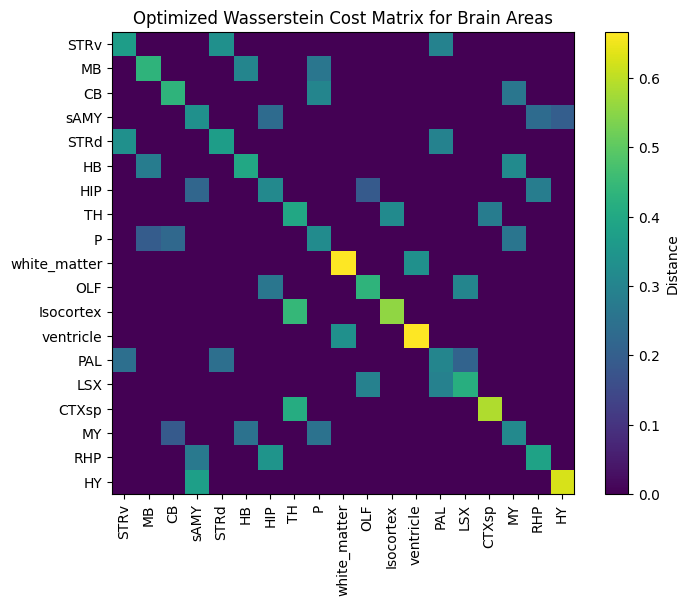

In [4]:
# List of brain regions
brain_areas = [
    "STRv", "MB", "CB", "sAMY", "STRd", "HB", "HIP", "TH", "P",
    "white_matter", "OLF", "Isocortex", "ventricle", "PAL", "LSX",
    "CTXsp", "MY", "RHP", "HY"
]

# Number of areas
n = len(brain_areas)

# Initialize cost matrix with high distances (default = 1.0)
cost_matrix = np.zeros((n, n))

# Define low and medium distances for similar regions
similarities = {
    ("STRv", "STRd"): 0.1, ("STRv", "PAL"): 0.2, ("STRd", "PAL"): 0.2, ("PAL", "LSX"): 0.3,
    ("MB", "HB"): 0.3, ("MB", "P"): 0.4, ("HB", "MY"): 0.2, ("P", "MY"): 0.2,
    ("CB", "P"): 0.3, ("CB", "MY"): 0.4,
    ("HIP", "RHP"): 0.1, ("HIP", "sAMY"): 0.3, ("RHP", "sAMY"): 0.3, ("sAMY", "HY"): 0.4,
    ("TH", "Isocortex"): 0.2, ("TH", "CTXsp"): 0.3,
    ("OLF", "LSX"): 0.3, ("OLF", "HIP"): 0.4,
    ("white_matter", "ventricle"): 0.5  # Both are non-neuronal
}

# Assign distances based on similarities dictionary
for (area1, area2), dist in similarities.items():
    i, j = brain_areas.index(area1), brain_areas.index(area2)
    cost_matrix[i, j] = 1 - dist
    cost_matrix[j, i] = 1 -dist  # Symmetric matrix
for i in range(len(brain_areas)):
    cost_matrix[i,i] = 1.0
    # Normalize the rows, s.t the distances are still comparable
    cost_matrix[i, :] = cost_matrix[i, :] / np.sum(cost_matrix[i])

# Convert to DataFrame for readability
cost_matrix_df = pd.DataFrame(cost_matrix, index=brain_areas, columns=brain_areas)

plt.figure(figsize=(8, 6))
plt.imshow(cost_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Distance")
plt.xticks(ticks=np.arange(n), labels=brain_areas, rotation=90)
plt.yticks(ticks=np.arange(n), labels=brain_areas)
plt.title("Optimized Wasserstein Cost Matrix for Brain Areas")
plt.show()


### Apply the distance matrix to the adatas

In [5]:
area_to_index = {area: i for i, area in enumerate(brain_areas)}

# Get the similarity matrix rows corresponding to each sample's brain area
adata_st.obsm["brain_area_similarities"] = np.array([
    cost_matrix[area_to_index[area]] for area in adata_st.obs["brain_area"]
])
adata_st.obsm["brain_area_similarities"].shape

(50000, 19)

In [6]:
adata_histo.obsm["brain_area_similarities"] = np.array([
    cost_matrix[area_to_index[area]] for area in adata_histo.obs["brain_area"]
])
adata_histo.obsm["brain_area_similarities"].shape

(190659, 19)

In [7]:
adata_histo.write_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_histo.h5ad")
adata_st.write_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_st.h5ad")

In [8]:
adata_st, adata_histo

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled', 'brain_area_similarities'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 190659 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample'
     obsm: 'brain_area_onehot', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords', 'brain_area_similarities')